In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import models, transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision import transforms

from torch.utils.data import DataLoader, SubsetRandomSampler

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import torch.cuda.amp as amp

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt

import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
bases_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Dataset/"
models_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/"

train_dataset_path = bases_path + "personal_Cleansed"
test_dataset_path = bases_path + "test/"
model_save_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/best_model.pth"  # Chemin de sauvegarde du modèle
full_model_save_path = "/content/drive/MyDrive/HackIA_2024_GRP_2/Models/full_best_model.pth"  # Chemin de sauvegarde du modèle

In [4]:
batch_size = 16  # @param [1,2,4,8,16,24,26, 32,64,128, 256] {type:"raw"}

input_dim = 224  # @param [32, 224,256,299,380] {type:"raw"}
image_size = (input_dim, input_dim)

epochs = 10  # @param [1, 5, 10,20,30,50,75, 100,200] {type:"raw"}

train_split = 0.9  # @param [0.9] {type:"raw"}

validation_split = 0.1  # @param [1e-1,2e-1,3e-1,4e-1] {type:"raw"}

# -------------------------
# Early Stopping call Back
# -------------------------
early_patience = 5 # @param [1,2,3,5,10,15,20,50,100] {type:"raw"}

optimizer_cost_function_train = "Adam"  # @param ["Adam", "SGD"]
train_learning_rate = 0.001 # @param [0.1,0.01,0.03, 0.003,0.0003,0.001,0.005,0.0001,0.00001] {type:"raw"}

optimizer_cost_function_refine = "SGD"  # @param ["Adam", "SGD"]
refine_learning_rate = 0.01 # @param [0.1,0.01,0.03,0.001,0.005,0.0001,0.00001] {type:"raw"}

dropout_rate = 0.5 # @param [0.0,0.1,0.2,0.3,0.4,0.5] {type:"raw"}

l2_rate = 0.00003 # @param [0,0.03,0.003,0.0003,0.00003] {type:"raw"}

nb_nodes = 1024 # @param [512,1024,2048] {type:"raw"}

head_layer = 5 # @param [1,2,3,4,5,6,7,8,12,20] {type:"raw"}

last_level = 256 # @param [128,256,512] {type:"raw"}

In [5]:
class ModelCheckpointCallback:
    def __init__(self, epoch_to_save, model_save_path):
        self.epoch_to_save = epoch_to_save
        self.model_save_path = model_save_path
        self.full_model_save_path = full_model_save_path
        self.best_accuracy = 0.0

    def __call__(self, epoch, model, accuracy):
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            torch.save(model.state_dict(), self.model_save_path)
            torch.save(model, self.full_model_save_path)
            print(f'Model saved at epoch {epoch} with accuracy {accuracy:.3f}')

In [6]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

In [10]:
# Charger EfficientNet-B0 pré-entraîné
model = models.efficientnet_b0(pretrained=True)

In [11]:
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 3)
)

In [12]:
# Déplacer le modèle sur le GPU si disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
# Afficher le modèle
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
# Transformations pour les données d'entraînement et de validation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [15]:
# Charger les données
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)

In [16]:
# Créer des indices pour le split train/validation
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(indices, test_size=validation_split, random_state=42)

In [17]:
# Création des samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Création des DataLoaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
valloader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=4)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [18]:
# Geler les premières couches du modèle
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
# Dégeler les couches à partir de la couche souhaitée
for name, child in model.features.named_children():
    if int(name) >= 7:  # Dégeler à partir de la couche 7
        for param in child.parameters():
            param.requires_grad = True

In [20]:
# Définir l'optimiseur et la fonction de perte
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.95)
criterion = nn.CrossEntropyLoss()

In [21]:
# Initialiser le modèle pour l'entraînement
fire_model = model

In [22]:
# Initialiser le callback
checkpoint_callback = ModelCheckpointCallback(early_patience, model_save_path)

In [23]:
# Utiliser le scaler pour la précision mixte
scaler = amp.GradScaler()

In [24]:
# Boucle d'entraînement et de validation
for epoch in range(epochs):
    fire_model.train()  # Mode entraînement
    running_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(trainloader, desc=f"Training Epoch {epoch+1}"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with amp.autocast():
            outputs = fire_model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        batch_correct, batch_total = calculate_accuracy(outputs, labels)
        correct += batch_correct
        total += batch_total

    train_loss = running_loss / len(trainloader)
    train_accuracy = correct / total
    print(f'Epoch {epoch + 1} Train Loss: {train_loss:.3f} Accuracy: {train_accuracy:.3f}')

    fire_model.eval()  # Mode évaluation
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data in tqdm(valloader, desc=f"Validation Epoch {epoch+1}"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            with amp.autocast():
                outputs = fire_model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item()

            batch_correct, batch_total = calculate_accuracy(outputs, labels)
            correct += batch_correct
            total += batch_total

    val_loss = running_loss / len(valloader)
    val_accuracy = correct / total
    print(f'Epoch {epoch + 1} Validation Loss: {val_loss:.3f} Accuracy: {val_accuracy:.3f}')

    # Appeler le callback après chaque époque
    checkpoint_callback(epoch + 1, fire_model, val_accuracy)

Training Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training Epoch 1: 100%|██████████| 97/97 [02:08<00:00,  1.32s/it]


Epoch 1 Train Loss: 0.927 Accuracy: 0.619


Validation Epoch 1: 100%|██████████| 11/11 [00:15<00:00,  1.40s/it]


Epoch 1 Validation Loss: 0.739 Accuracy: 0.797
Model saved at epoch 1 with accuracy 0.797


Training Epoch 2: 100%|██████████| 97/97 [00:08<00:00, 11.75it/s]


Epoch 2 Train Loss: 0.543 Accuracy: 0.812


Validation Epoch 2: 100%|██████████| 11/11 [00:01<00:00,  6.37it/s]


Epoch 2 Validation Loss: 0.506 Accuracy: 0.826
Model saved at epoch 2 with accuracy 0.826


Training Epoch 3: 100%|██████████| 97/97 [00:08<00:00, 11.81it/s]


Epoch 3 Train Loss: 0.389 Accuracy: 0.864


Validation Epoch 3: 100%|██████████| 11/11 [00:01<00:00,  6.35it/s]


Epoch 3 Validation Loss: 0.464 Accuracy: 0.849
Model saved at epoch 3 with accuracy 0.849


Training Epoch 4: 100%|██████████| 97/97 [00:08<00:00, 11.55it/s]


Epoch 4 Train Loss: 0.349 Accuracy: 0.873


Validation Epoch 4: 100%|██████████| 11/11 [00:01<00:00,  6.43it/s]


Epoch 4 Validation Loss: 0.458 Accuracy: 0.837


Training Epoch 5: 100%|██████████| 97/97 [00:07<00:00, 12.94it/s]


Epoch 5 Train Loss: 0.306 Accuracy: 0.888


Validation Epoch 5: 100%|██████████| 11/11 [00:02<00:00,  5.07it/s]


Epoch 5 Validation Loss: 0.440 Accuracy: 0.826


Training Epoch 6: 100%|██████████| 97/97 [00:08<00:00, 11.60it/s]


Epoch 6 Train Loss: 0.281 Accuracy: 0.905


Validation Epoch 6: 100%|██████████| 11/11 [00:01<00:00,  6.68it/s]


Epoch 6 Validation Loss: 0.414 Accuracy: 0.849


Training Epoch 7: 100%|██████████| 97/97 [00:08<00:00, 11.63it/s]


Epoch 7 Train Loss: 0.274 Accuracy: 0.902


Validation Epoch 7: 100%|██████████| 11/11 [00:01<00:00,  6.46it/s]


Epoch 7 Validation Loss: 0.418 Accuracy: 0.872
Model saved at epoch 7 with accuracy 0.872


Training Epoch 8: 100%|██████████| 97/97 [00:07<00:00, 12.82it/s]


Epoch 8 Train Loss: 0.256 Accuracy: 0.903


Validation Epoch 8: 100%|██████████| 11/11 [00:01<00:00,  7.73it/s]


Epoch 8 Validation Loss: 0.439 Accuracy: 0.860


Training Epoch 9: 100%|██████████| 97/97 [00:08<00:00, 11.86it/s]


Epoch 9 Train Loss: 0.237 Accuracy: 0.916


Validation Epoch 9: 100%|██████████| 11/11 [00:01<00:00,  6.33it/s]


Epoch 9 Validation Loss: 0.363 Accuracy: 0.855


Training Epoch 10: 100%|██████████| 97/97 [00:08<00:00, 11.61it/s]


Epoch 10 Train Loss: 0.251 Accuracy: 0.913


Validation Epoch 10: 100%|██████████| 11/11 [00:01<00:00,  6.33it/s]


Epoch 10 Validation Loss: 0.397 Accuracy: 0.878
Model saved at epoch 10 with accuracy 0.878


In [25]:
# Mettre le modèle en mode évaluation
fire_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [26]:
# Désactiver le calcul des gradients pour économiser de la mémoire et accélérer le traitement
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0

    for data in tqdm(testloader, desc="Testing"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with amp.autocast():
            outputs = fire_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            probs = nn.functional.softmax(outputs, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_loss /= len(testloader)
    accuracy = correct / total

    print(f'Test Loss: {test_loss:.3f}')
    print(f'Test Accuracy: {accuracy:.3f}')

Testing: 100%|██████████| 19/19 [00:36<00:00,  1.92s/it]

Test Loss: 0.537
Test Accuracy: 0.803


In [27]:
# Renommer (déplacer) le fichier de modèle avec la précision de test
final_model_save_path = f"{models_path}model_DenseNet_200_Weights_test_acc_{accuracy:.3f}.pth"
shutil.move(checkpoint_callback.model_save_path, final_model_save_path)
print(f'Model saved as {final_model_save_path}')

Model saved as /content/drive/MyDrive/HackIA_2024_GRP_2/Models/model_DenseNet_200_Weights_test_acc_0.803.pth


In [28]:
# Renommer (déplacer) le fichier de modèle avec la précision de test
full_final_model_save_path = f"{models_path}full_model_DenseNet_200_test_acc_{accuracy:.3f}.pth"
shutil.move(checkpoint_callback.full_model_save_path, full_final_model_save_path)
print(f'Model saved as {full_final_model_save_path}')


Model saved as /content/drive/MyDrive/HackIA_2024_GRP_2/Models/full_model_DenseNet_200_test_acc_0.803.pth


ROC-AUC: 0.930
F1 Score: 0.804
Confusion Matrix:
[[82  5 13]
 [16 75  9]
 [12  4 84]]


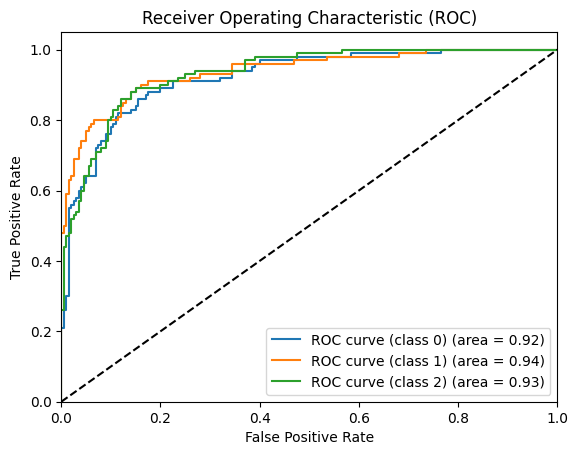

In [29]:
# Convert lists to numpy arrays for metric calculations
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

# Calculer les métriques supplémentaires
roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
f1 = f1_score(all_labels, all_predictions, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f'ROC-AUC: {roc_auc:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'Confusion Matrix:\n{conf_matrix}')

# Tracer la courbe ROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [30]:
# Afficher 5 images aléatoires par classe
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

Classe: fire


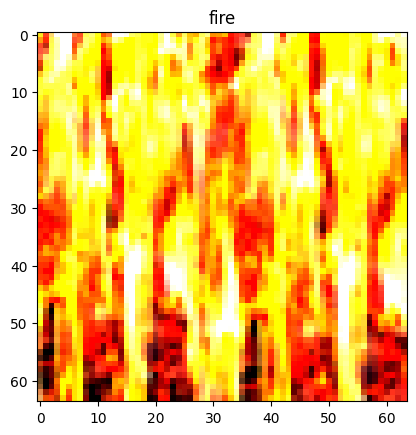

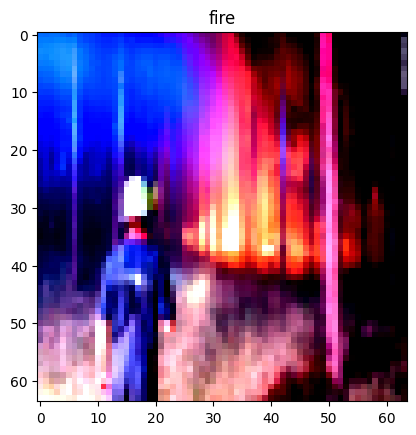

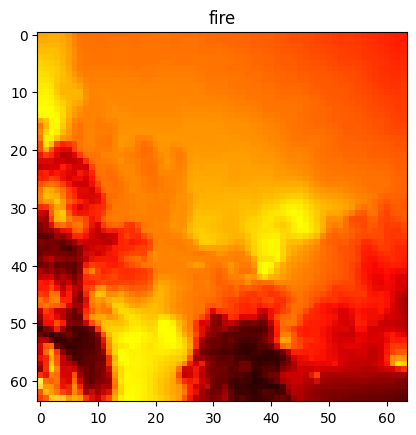

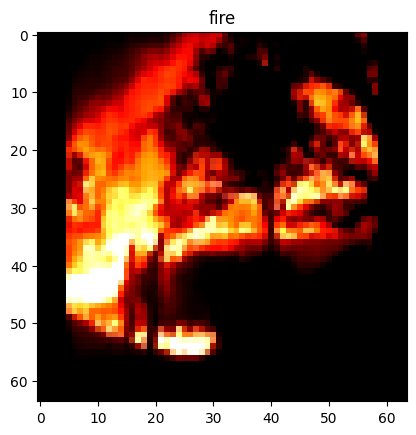

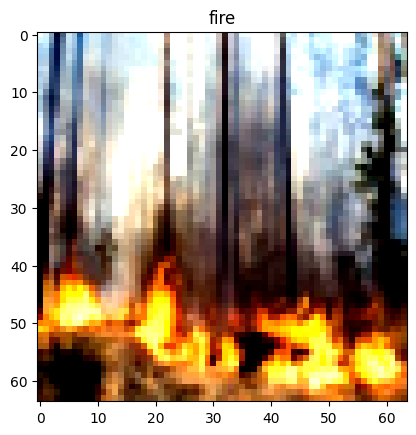

Classe: no_fire


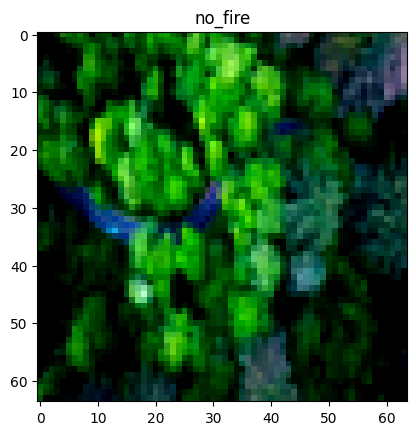

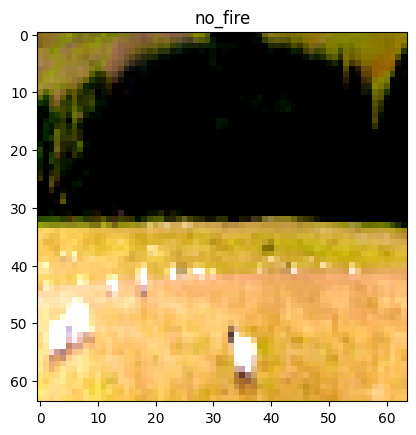

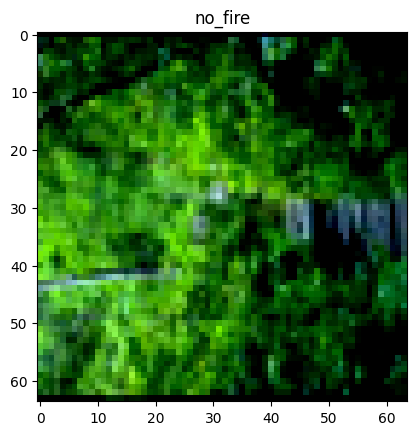

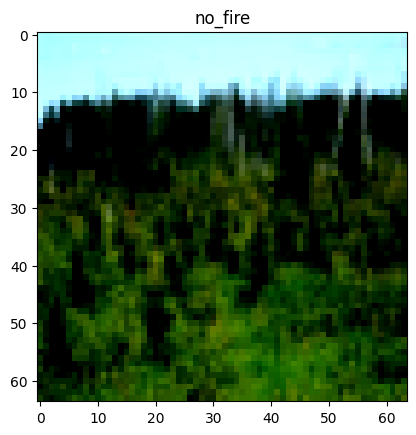

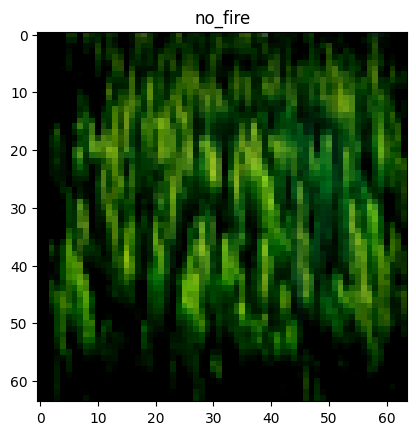

Classe: start_fire


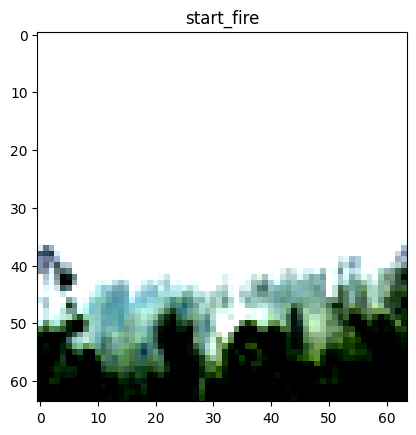

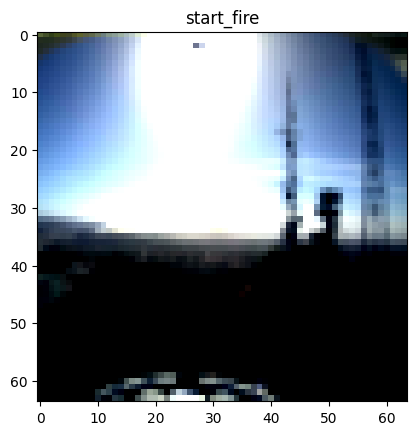

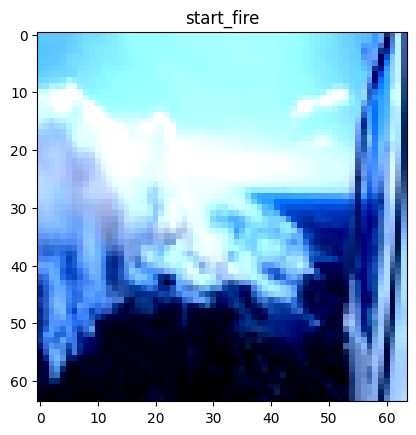

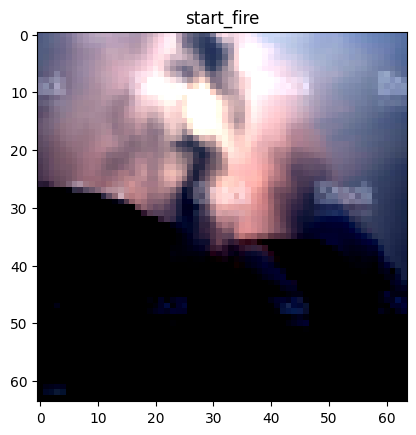

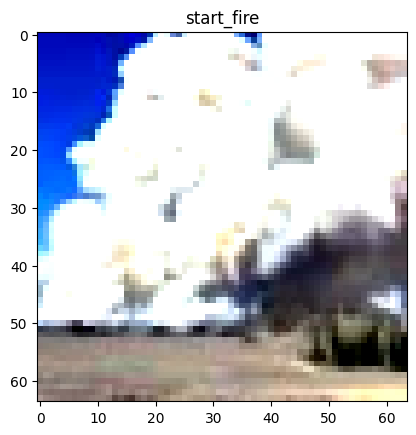

In [31]:
classes = train_dataset.classes  # Utilisez les mêmes classes que pour l'entraînement
for cls in classes:
    cls_idx = train_dataset.class_to_idx[cls]
    cls_indices = [i for i, label in enumerate(train_dataset.targets) if label == cls_idx]
    random_indices = np.random.choice(cls_indices, 5, replace=False)
    print(f"Classe: {cls}")
    for idx in random_indices:
        img, _ = train_dataset[idx]
        imshow(img, cls)